In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm


from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMAGE_PATH = '/home/morten/Documents/Algorithms-for-Automated-Driving/code/solutions/lane_detection/data_lane_segmentation/train/'
MASK_PATH = '/home/morten/Documents/Algorithms-for-Automated-Driving/code/solutions/lane_detection/data_lane_segmentation/train_label/'

In [3]:
n_classes = 3

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))


Total Images:  3075


In [4]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
print(X_trainval[0])
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

print(X_train[0])

Town04_Clear_Noon_09_09_2020_14_57_22_frame_2545
Train Size   :  2351
Val Size     :  416
Test Size    :  308
Town04_Clear_Noon_09_09_2020_14_57_22_frame_3197


Image Size (512, 1024, 3)
Mask Size (512, 1024)


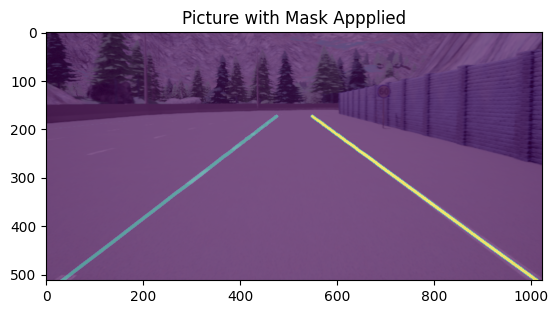

In [5]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + df['id'][100] + '_label.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()


In [6]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '_label.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches



In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

print(type(train_set))

print(train_set[5][1].shape)

#dataloader
batch_size= 2

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True) 

for step, (x,y) in enumerate(train_loader):
    if step < 3:
        print(x.shape, y.shape)
    else:
        break




<class '__main__.DroneDataset'>
torch.Size([704, 1056])
torch.Size([2, 3, 704, 1056]) torch.Size([2, 704, 1056])
torch.Size([2, 3, 704, 1056]) torch.Size([2, 704, 1056])
torch.Size([2, 3, 704, 1056]) torch.Size([2, 704, 1056])


In [151]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=3, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])


In [152]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


In [153]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [154]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [143]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))


torch.cuda.empty_cache()


history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)



|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 6            |        cudaMalloc retries: 6         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 143037 KiB |   4549 MiB |   4580 MiB |   4440 MiB |
|       from large pool | 100208 KiB |   4502 MiB |   4524 MiB |   4427 MiB |
|       from small pool |  42829 KiB |     47 MiB |     55 MiB |     13 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 143037 KiB |   4549 MiB |   4580 MiB |   4440 MiB |
|       from large pool | 100208 KiB |   4502 MiB |   4524 MiB |

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.050 
Epoch:1/15.. Train Loss: 0.234.. Val Loss: 0.050.. Train mIoU:0.342.. Val mIoU: 0.437.. Train Acc:0.956.. Val Acc:0.988.. Time: 7.95m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.050 >> 0.028 
Epoch:2/15.. Train Loss: 0.051.. Val Loss: 0.028.. Train mIoU:0.424.. Val mIoU: 0.478.. Train Acc:0.988.. Val Acc:0.990.. Time: 8.03m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.028 >> 0.023 
Epoch:3/15.. Train Loss: 0.044.. Val Loss: 0.023.. Train mIoU:0.436.. Val mIoU: 0.502.. Train Acc:0.988.. Val Acc:0.990.. Time: 7.89m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/15.. Train Loss: 0.043.. Val Loss: 0.023.. Train mIoU:0.441.. Val mIoU: 0.503.. Train Acc:0.988.. Val Acc:0.990.. Time: 7.98m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.023 >> 0.023 
saving model...
Epoch:5/15.. Train Loss: 0.042.. Val Loss: 0.023.. Train mIoU:0.448.. Val mIoU: 0.527.. Train Acc:0.989.. Val Acc:0.991.. Time: 8.03m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.023 >> 0.022 
Epoch:6/15.. Train Loss: 0.042.. Val Loss: 0.022.. Train mIoU:0.451.. Val mIoU: 0.530.. Train Acc:0.989.. Val Acc:0.991.. Time: 8.03m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.022 >> 0.021 
Epoch:7/15.. Train Loss: 0.039.. Val Loss: 0.021.. Train mIoU:0.458.. Val mIoU: 0.515.. Train Acc:0.989.. Val Acc:0.991.. Time: 8.03m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.021 >> 0.019 
Epoch:8/15.. Train Loss: 0.039.. Val Loss: 0.019.. Train mIoU:0.463.. Val mIoU: 0.538.. Train Acc:0.989.. Val Acc:0.991.. Time: 8.07m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/15.. Train Loss: 0.039.. Val Loss: 0.020.. Train mIoU:0.469.. Val mIoU: 0.558.. Train Acc:0.989.. Val Acc:0.991.. Time: 7.99m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.020 >> 0.019 
Epoch:10/15.. Train Loss: 0.038.. Val Loss: 0.019.. Train mIoU:0.480.. Val mIoU: 0.562.. Train Acc:0.989.. Val Acc:0.992.. Time: 8.08m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/15.. Train Loss: 0.037.. Val Loss: 0.019.. Train mIoU:0.481.. Val mIoU: 0.561.. Train Acc:0.989.. Val Acc:0.992.. Time: 8.07m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.019 >> 0.018 
saving model...
Epoch:12/15.. Train Loss: 0.037.. Val Loss: 0.018.. Train mIoU:0.485.. Val mIoU: 0.569.. Train Acc:0.989.. Val Acc:0.992.. Time: 8.15m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.018 >> 0.017 
Epoch:13/15.. Train Loss: 0.036.. Val Loss: 0.017.. Train mIoU:0.496.. Val mIoU: 0.569.. Train Acc:0.990.. Val Acc:0.992.. Time: 7.99m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.017 >> 0.017 
Epoch:14/15.. Train Loss: 0.035.. Val Loss: 0.017.. Train mIoU:0.504.. Val mIoU: 0.575.. Train Acc:0.990.. Val Acc:0.992.. Time: 7.95m


  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Loss Decreasing.. 0.017 >> 0.017 
Epoch:15/15.. Train Loss: 0.034.. Val Loss: 0.017.. Train mIoU:0.513.. Val mIoU: 0.570.. Train Acc:0.990.. Val Acc:0.992.. Time: 8.02m
Total time: 120.24 m
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 6            |        cudaMalloc retries: 6         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 223406 KiB |   4549 MiB | 182606 GiB | 182606 GiB |
|       from large pool | 158941 KiB |   4502 MiB | 181677 GiB | 181677 GiB |
|       from small pool |  64465 KiB |     83 MiB |    928 GiB |    928 GiB |
|-----------------------------

In [18]:
model_lane = torch.load('Unet-Mobilenet_v2_mIoU-0.569.pt')

model_lane.eval()
model_lane = model_lane.to(device=device)
src = '/home/morten/Documents/Algorithms-for-Automated-Driving/code/solutions/lane_detection/data_lane_segmentation/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_641_validation_set.png'

img = cv2.imread(src)

img = torch.from_numpy(img).float()
img = torch.swapaxes(img, 0, 2)
img = torch.unsqueeze(img, 0)
img = img.to(device=device)
print(img.shape)

with torch.no_grad():
    result = model_lane(img)

result = torch.squeeze(result, 0)
result = torch.swapaxes(result, 0, 2)

print(result.shape)
result = result.cpu().detach().numpy()
print(result.shape)
print(result)
# plt.show(result.all())



torch.Size([1, 3, 1024, 512])
torch.Size([512, 1024, 3])
(512, 1024, 3)
[[[ 2.460341  -1.8571188 -1.5365429]
  [ 2.82715   -2.2212245 -1.9940636]
  [ 2.7340052 -2.2518952 -1.9282217]
  ...
  [ 3.2726622 -2.6603103 -2.9867578]
  [ 3.5228868 -3.0594513 -2.7502553]
  [ 2.8561075 -1.8965225 -2.3105948]]

 [[ 2.9184933 -1.9837816 -1.5793898]
  [ 3.8877633 -2.754375  -2.1569672]
  [ 3.7514904 -2.6327734 -2.0206676]
  ...
  [ 4.1347857 -2.8639443 -3.63877  ]
  [ 4.619274  -3.5509138 -3.3946352]
  [ 4.0574856 -2.6159585 -2.470619 ]]

 [[ 2.8910034 -1.9990772 -1.3789456]
  [ 3.95765   -2.8071136 -1.9177333]
  [ 3.602772  -2.5386884 -1.7855173]
  ...
  [ 3.7300427 -2.3688188 -3.600626 ]
  [ 4.29      -3.114174  -3.3798573]
  [ 4.0506396 -2.4771774 -2.559301 ]]

 ...

 [[ 4.546007  -4.0195355 -3.1066735]
  [ 6.613647  -5.571568  -4.218659 ]
  [ 6.326968  -5.326762  -4.0134425]
  ...
  [ 3.7581234 -3.3187113 -2.0455043]
  [ 4.1980095 -3.1466048 -2.2004008]
  [ 3.1408317 -2.1410458 -1.9238808]]

 [